Question 1: Make Trackbar for the following images to tune the parameters of canny 
            detection.

In [87]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [88]:
def nothing(x):
    print(x)

In [89]:
# Convert BGR images to gray images
def convert_to_gray(img):
    if len(img.shape) == 2:
        print('2 channels')
        print(img.shape)
        return img
    else:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [90]:
def find_edges(img, t1, t2):
    blur = cv2.GaussianBlur(img, (5,5), 0)
    return cv2.Canny(blur, t1, t2)

In [104]:
img1_original = cv2.imread('Q1/solidWhiteCurve.jpg', cv2.IMREAD_COLOR)
img2_original = cv2.imread('Q1/solidYellowCurve2.jpg', cv2.IMREAD_COLOR)

img1 = convert_to_gray(img1_original)
img2 = convert_to_gray(img2_original)

cv2.namedWindow('image 1')
cv2.namedWindow('image 2')

cv2.createTrackbar('t1', 'image 1', 0, 150, nothing)
cv2.createTrackbar('t2', 'image 1', 0, 150, nothing)
cv2.createTrackbar('t1', 'image 2', 0, 150, nothing)
cv2.createTrackbar('t2', 'image 2', 0, 150, nothing)

while 1:
    t1_img1 = cv2.getTrackbarPos('t1', 'image 1')
    t2_img1 = cv2.getTrackbarPos('t2', 'image 1')
    t1_img2 = cv2.getTrackbarPos('t1', 'image 2')
    t2_img2 = cv2.getTrackbarPos('t2', 'image 2')
    
    img1_edged = find_edges(img1, t1_img1, t2_img1)
    img2_edged = find_edges(img2, t1_img2, t2_img2)
    
    cv2.imshow('image 1', img1_edged)
    cv2.imshow('image 2', img2_edged)
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        print('You closed all windows')
        break

cv2.destroyAllWindows()

1
2
5
8
13
21
30
41
54
66
79
94
109
123
136
148
150
1
3
5
8
14
22
32
44
58
74
90
106
123
138
150
1
2
3
4
5
7
8
9
10
11
12
13
15
16
18
21
25
32
39
49
60
72
84
97
111
124
137
150
1
2
4
8
13
21
30
40
50
62
74
86
97
108
119
130
141
150
You closed all windows


Question 2: The out of question 1 make it as input for question 2 after make region of 
            interest then make trackbar for houghlines parameters (threshold ,min_line_length
            max_line_gap) and then draw 2 line on image.

In [92]:
def apply_mask(img):
    # Step 1: create masks for each image
    mask = np.zeros_like(img)
    
    # Step 2: Create a numpy array for each polygon points
    vert = np.array(
      [
        [
          (int(mask.shape[1]*5/12), int(mask.shape[0]*3/5)),
          (int(mask.shape[1]*7/12), int(mask.shape[0]*3/5)),
          (int(mask.shape[1]*11/12), mask.shape[0]),
          (int(mask.shape[1]/12), mask.shape[0])
        ]
      ]
    )
    
    # Step 3: Draw a polygon of the area we want in each image
    cv2.fillPoly(mask, vert, 255)   # 255 refers to white color
    
    # Step 4: Anding between edged image and masked one (apply mask)
    masked = cv2.bitwise_and(img, mask)
    
    return masked

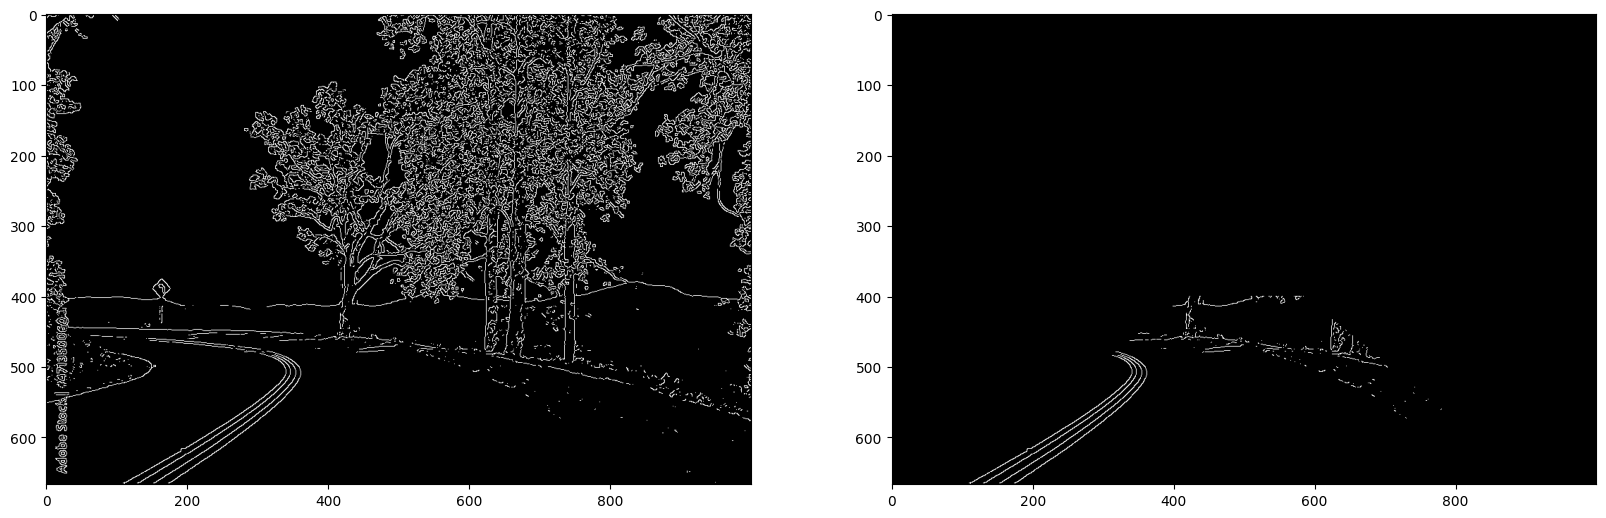

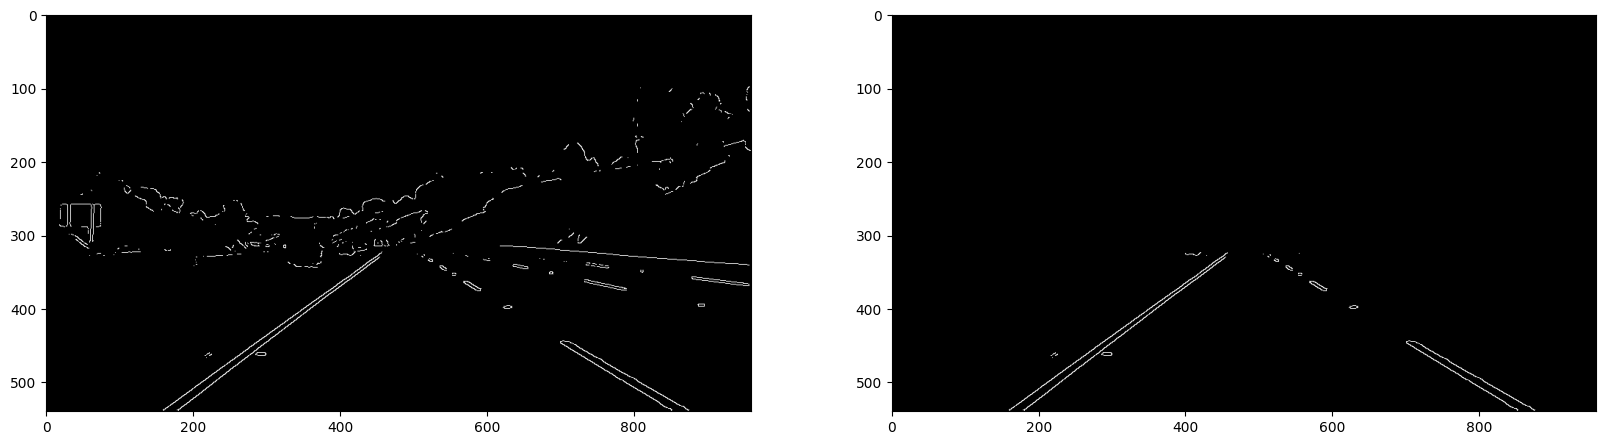

In [93]:
masked1 = apply_mask(img1_edged)
masked2 = apply_mask(img2_edged)

# Show the steps of image 1
fig1, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
ax0.imshow(img1_edged, cmap='gray')
ax1.imshow(masked1, cmap='gray');

# Show the steps of image 2
fig2, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
ax0.imshow(img2_edged, cmap='gray')
ax1.imshow(masked2, cmap='gray');


In [94]:
def get_hough_lines(img):
  return cv2.HoughLinesP(img, 4, np.pi/180, 10, 5, 10)

In [95]:
def draw_lines(img, lines):
  lines_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
  for line in lines:
    for x1,y1,x2,y2 in line:
      cv2.line(lines_img, (x1, y1), (x2, y2), [255,0,0], 15)
  return lines_img

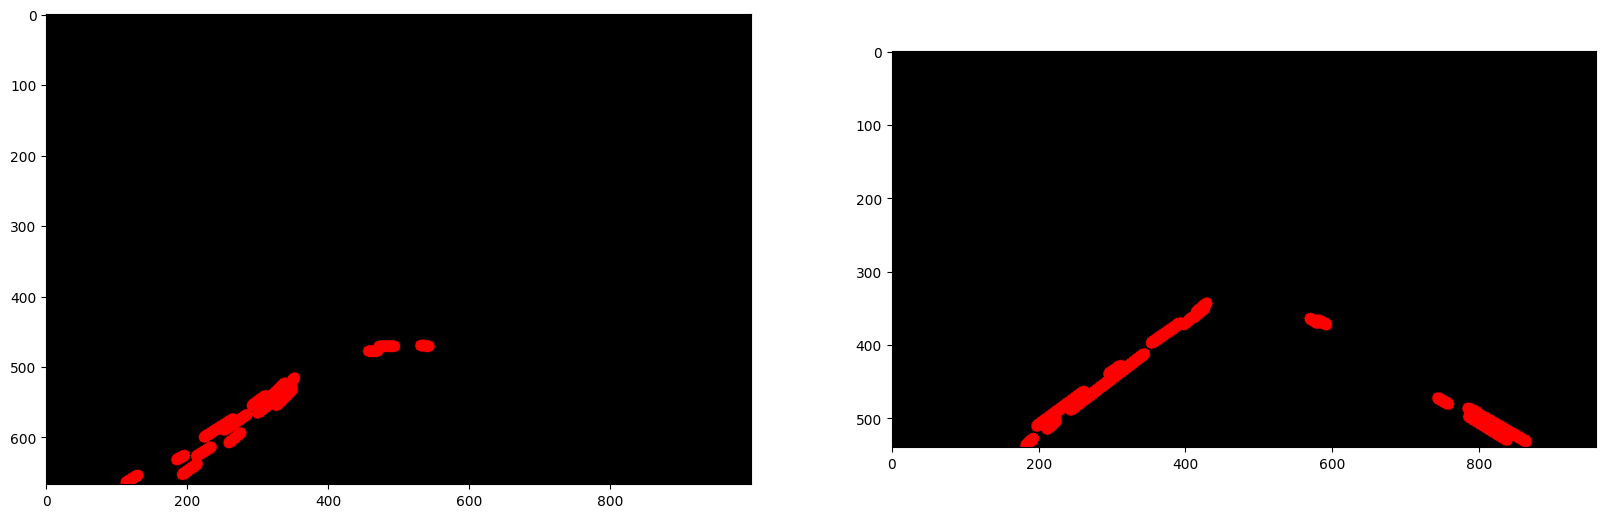

In [96]:
def lined(img, img_lines):
    return draw_lines(img, img_lines)

img1_lines = get_hough_lines(masked1)
img2_lines = get_hough_lines(masked2)

lined_img1 = lined(masked1, img1_lines)
lined_img2 = lined(masked2, img2_lines)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
ax0.imshow(lined_img1, cmap='gray')
ax1.imshow(lined_img2, cmap='gray')

In [97]:
def formulate_lanes(lines, img):
    negative_slopes = []
    positive_slopes = []

    negative_intercepts = []
    positive_intercepts = []

    y_min = img.shape[0]
    y_max = img.shape[0]

    for line in lines:
        for x1, y1, x2, y2 in line:
          slope = (y2-y1) / (x2-x1)     # Slope of a straight line
          intercept = y2 - slope*x2     # Intercept of a straight line
    
          y_min = min(y_min, y1, y2)    # find the minimum point of line (start point)
    
          if slope > 0.0:
            positive_slopes.append(slope)
            positive_intercepts.append(intercept)
    
          elif slope < 0.0:
            negative_slopes.append(slope)
            negative_intercepts.append(intercept)
    
    # After this loop we will get the start point of the lanes in Y-axis
    # y-max (end point of the lanes) is always the start of the image from bottom
    
    # get the mean of positive and negative slopes lists
    positive_slope = np.mean(positive_slopes)
    negative_slope = np.mean(negative_slopes)
    
    # get the mean of positive and negative intercepts lists
    positive_intercept = np.mean(positive_intercepts)
    negative_intercept = np.mean(negative_intercepts)
    
    # Create start and end points of each lane
    pts = [
      [[0,0, 0,0]],
      [[0,0, 0,0]]
    ]

    # +ve slope line
    if len(positive_slopes) > 0:    # If there is any slope in the positive slopes list
      x_max = (y_max - positive_intercept) / positive_slope     # if y = slope * x + intercept ... then x = (y - intercept) / slope
      x_min = (y_min - positive_intercept) / positive_slope
      pts[0][0] = [x_min, y_min, x_max, y_max]
    
    # -ve slope line
    if len(negative_slopes) > 0:
      x_max = (y_max - negative_intercept) / negative_slope
      x_min = (y_min - negative_intercept) / negative_slope
      pts[1][0] = [x_min, y_min, x_max, y_max]
  
    return np.array(pts, dtype=np.int32)    # array of start and end points of two lines (lanes)

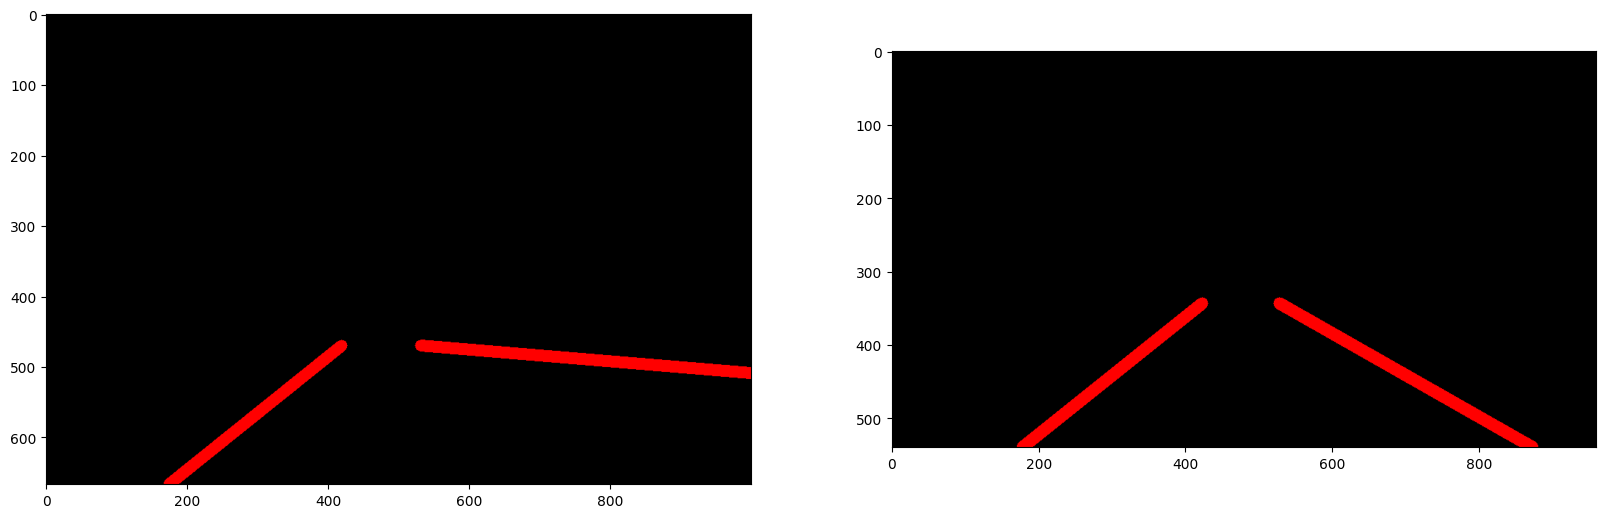

In [98]:
img1_lanes = formulate_lanes(img1_lines, masked1)
img2_lanes = formulate_lanes(img2_lines, masked2)

lanes_img1 = draw_lines(masked1, img1_lanes)
lanes_img2 = draw_lines(masked2, img2_lanes)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
ax0.imshow(lanes_img1, cmap='gray')
ax1.imshow(lanes_img2, cmap='gray')

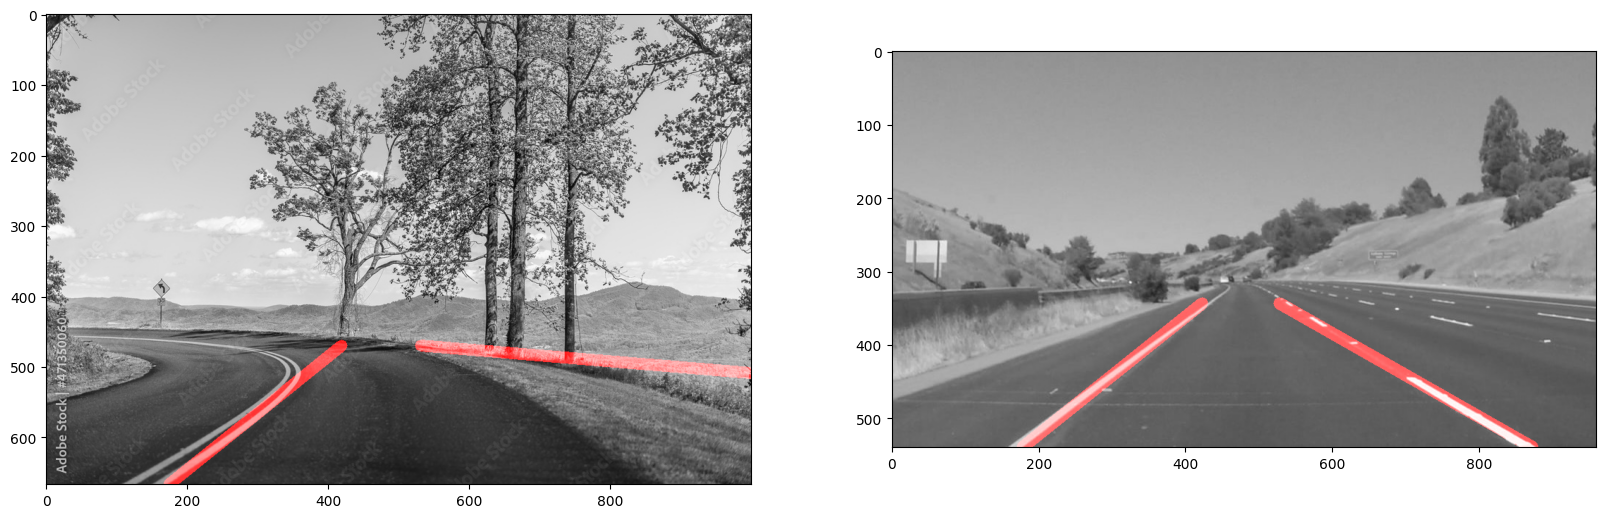

In [99]:
# Convert the images to RGB format
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

output1 = cv2.addWeighted(img1_rgb, 1, lanes_img1, 1, 0)
output2 = cv2.addWeighted(img2_rgb, 1, lanes_img2, 1, 0)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
ax0.imshow(output1, cmap='gray')
ax1.imshow(output2, cmap='gray')

Final Application

In [100]:
def process_image(img):
    try:
        gray = convert_to_gray(img)
        edges = find_edges(gray, 150, 150)
        masked = apply_mask(edges)
        lines = get_hough_lines(masked)
        lanes = formulate_lanes(lines, masked)
        lined_img = draw_lines(masked, lanes)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        output = cv2.addWeighted(img, 1, lined_img, 1, 0)
    except Exception as e:
        print(f"Error processing image: {e}")
        output = img
    return output

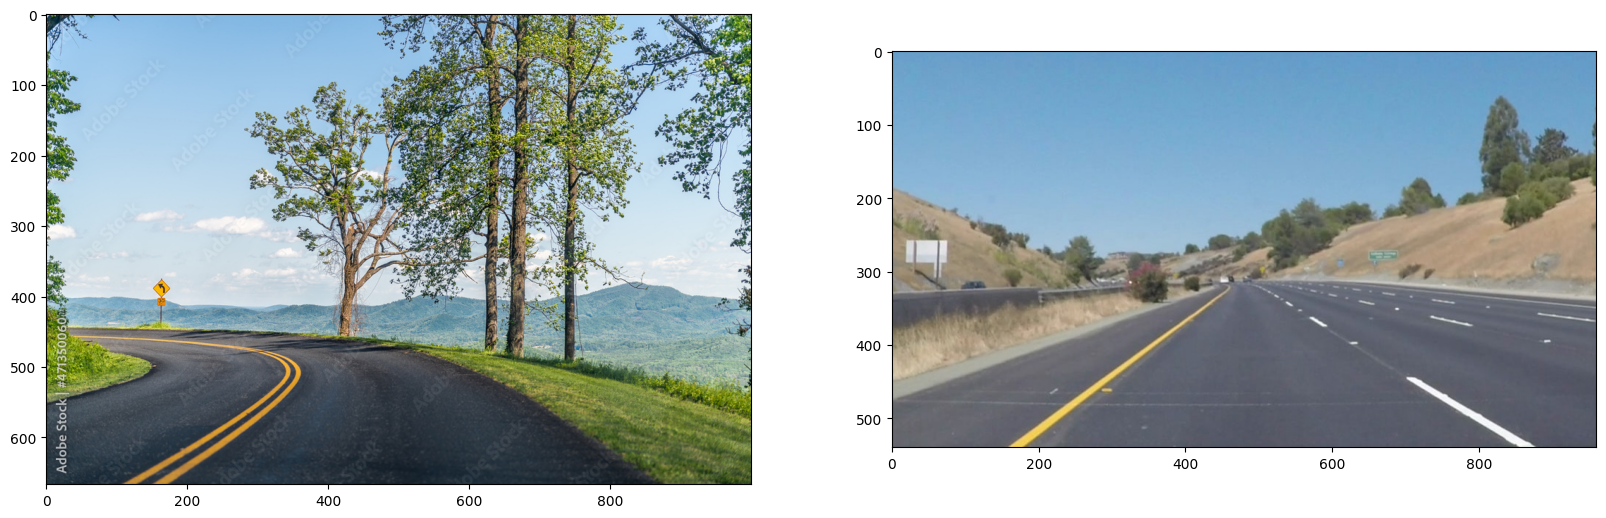

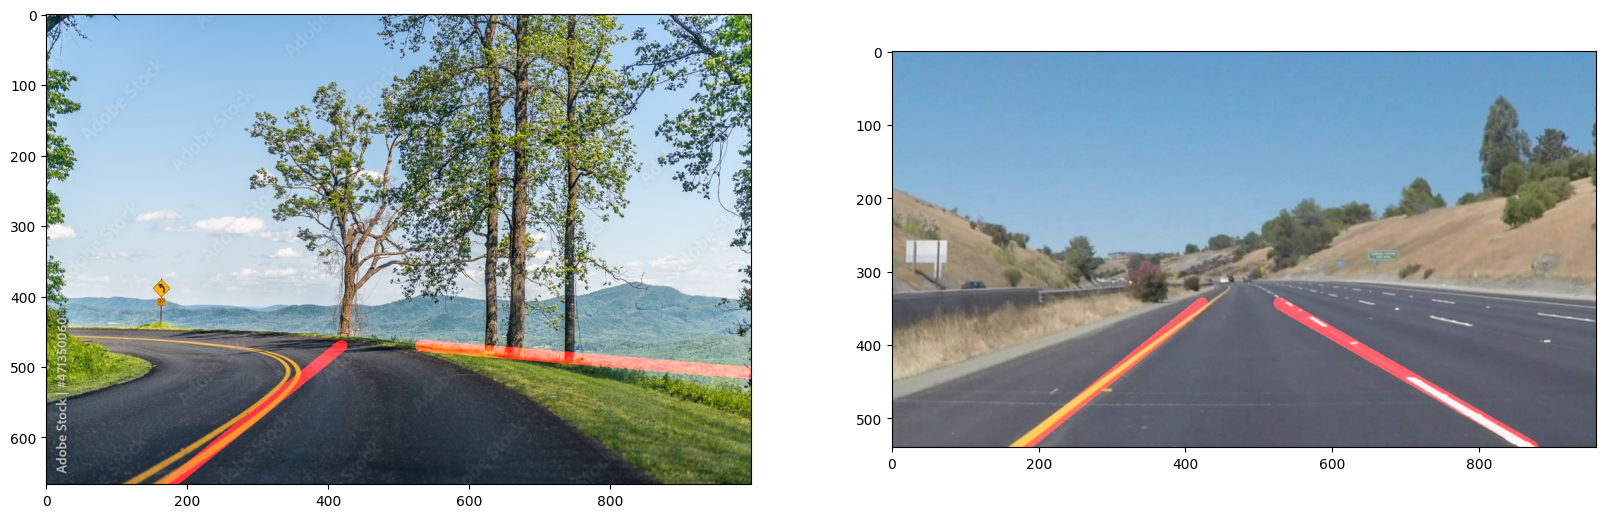

In [101]:
output1 = process_image(img1_original)
output2 = process_image(img2_original)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
ax0.imshow(cv2.cvtColor(img1_original, cv2.COLOR_BGR2RGB), cmap='gray')
ax1.imshow(cv2.cvtColor(img2_original, cv2.COLOR_BGR2RGB), cmap='gray')

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 10))
ax0.imshow(output1, cmap='gray')
ax1.imshow(output2, cmap='gray')

----------------------------------------------------End of question 2----------------------------------------------------

Question 3: read the following video and apply lane line detection on it then show output using opencv.

In [102]:
from IPython.display import HTML
from moviepy.editor import VideoFileClip

input_path = 'lanelines/test_videos/challenge.mp4'
output_path = 'Q3/challenge.mp4'

input_video = VideoFileClip(input_path)
output_video = input_video.fl_image(process_image)
output_video.write_videofile(output_path, audio=False)

Moviepy - Building video Q3/challenge.mp4.
Moviepy - Writing video Q3/challenge.mp4


Moviepy - Done !
Moviepy - video ready Q3/challenge.mp4


In [103]:
HTML(f"""
     <video width="960" height="540" controls>
      <source src="{output_path}">
     </ video>
""")